<a href="https://colab.research.google.com/github/ladofa/edu/blob/master/Example_voice_emotion_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

import librosa
import librosa.display

import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd  
import math
import os

# 데이터 준비

In [2]:
!git clone https://github.com/siddiquelatif/URDU-Dataset.git

Cloning into 'URDU-Dataset'...
remote: Enumerating objects: 442, done.
remote: Total 442 (delta 0), reused 0 (delta 0), pack-reused 442
Receiving objects: 100% (442/442), 72.05 MiB | 44.37 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [3]:
labels = {
    'Angry':0,
    'Happy':1,
    'Neutral':2,
    'Sad':3
}

In [4]:
data = []
for root, dirs, filenames in os.walk('URDU-Dataset'):
    base = os.path.basename(root)
    if base not in labels:
        continue
    label = labels[base]
    for filename in filenames:
        first, last = os.path.splitext(filename)
        if last != '.wav':
            continue
        path = os.path.join(root, filename)
        data.append((path, label))

In [5]:
n_mfcc = 13
batch_size = 16
sr = 11025
duration = 3
max_len = int(sr * duration)

# 음성 데이터 불러오기

In [6]:
data[:10]

[('URDU-Dataset/Sad/SM25_F18_S068.wav', 3),
 ('URDU-Dataset/Sad/SM25_F33_S083.wav', 3),
 ('URDU-Dataset/Sad/SM26_F2_S092.wav', 3),
 ('URDU-Dataset/Sad/SM25_F2_S052.wav', 3),
 ('URDU-Dataset/Sad/SM25_F32_S082.wav', 3),
 ('URDU-Dataset/Sad/SM24_F36_S048.wav', 3),
 ('URDU-Dataset/Sad/SM24_F35_S047.wav', 3),
 ('URDU-Dataset/Sad/SM25_F12_S062.wav', 3),
 ('URDU-Dataset/Sad/SM25_F38_S088.wav', 3),
 ('URDU-Dataset/Sad/SM24_F5_S017.wav', 3)]

In [7]:
sample = data[0]

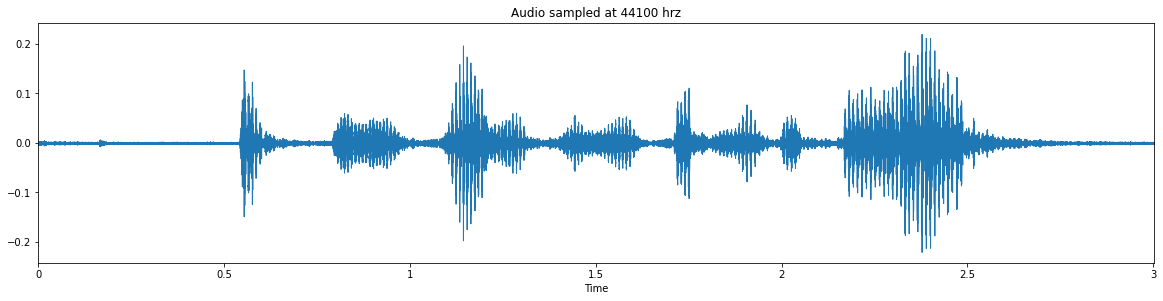

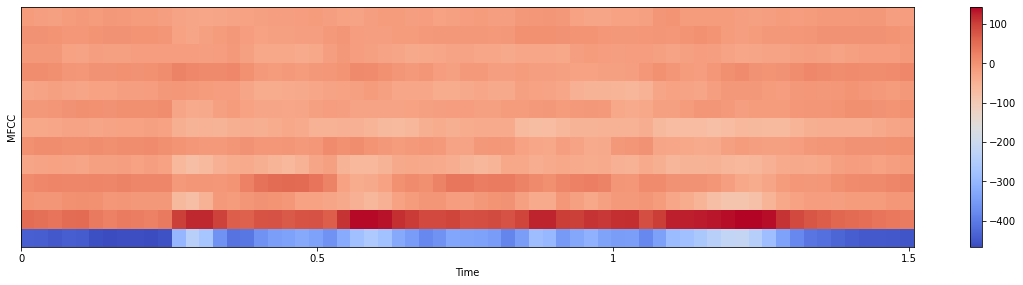

In [8]:
Xf, sample_ratef = librosa.load(sample[0], 
                                res_type='kaiser_fast', sr=sr)  
mfcc = librosa.feature.mfcc(y=Xf, sr=sample_ratef, n_mfcc=n_mfcc)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(Xf, sr=sample_ratef)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(Xf, rate=sample_ratef)


# 프리프로세싱

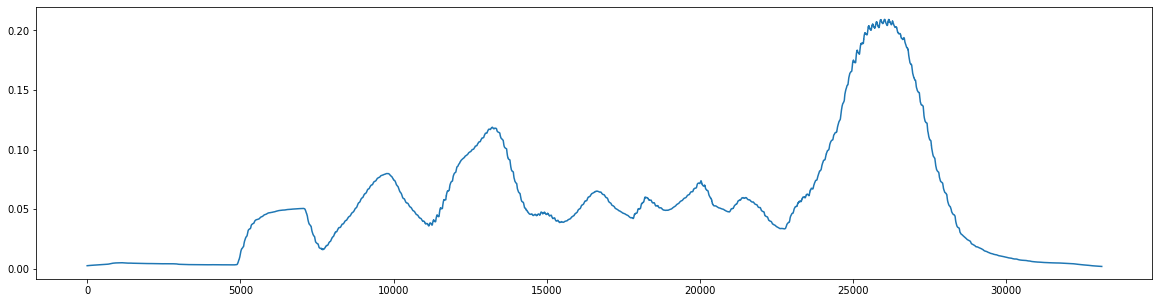

In [9]:
mask_size = int(sr * 0.2) # 0.2초
mask = np.ones(mask_size) / mask_size
filter = mask[..., None, None]
Xf = Xf / max(Xf)
conv = tf.nn.conv1d(abs(Xf[None, :, None]).astype(np.float), filter, stride=1, padding='SAME')
conv = conv.numpy().reshape(-1)
# conv = np.convolve(abs(Xf), mask)
plt.figure(figsize=(20, 5))
plt.plot(conv)

14996 33114


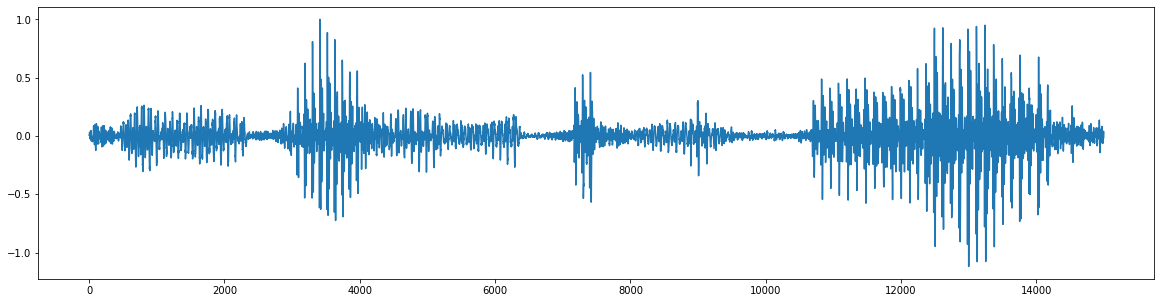

In [10]:
filtered = Xf[conv > 0.05]
plt.figure(figsize=(20, 5))
plt.plot(filtered)
print(len(filtered), len(Xf))
ipd.Audio(filtered, rate=sr)

In [11]:
shorten = filtered[-max_len:]
if len(shorten) < max_len:
    shorten = np.concatenate([np.zeros(max_len - len(shorten)), shorten])

ipd.Audio(shorten, rate=sr)

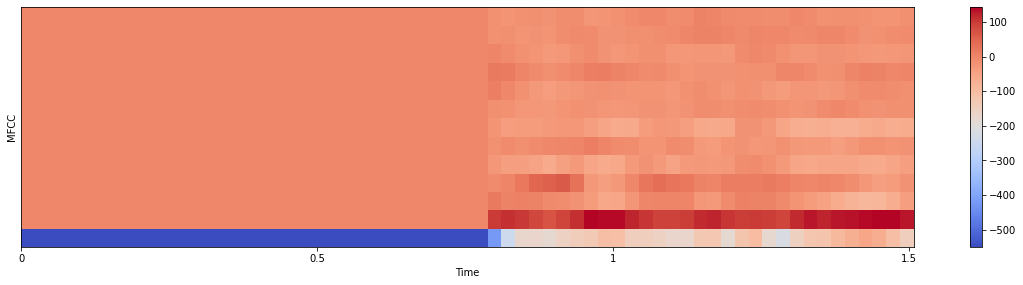

In [12]:
mfcc = librosa.feature.mfcc(y=shorten, sr=sample_ratef, n_mfcc=n_mfcc)
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

In [13]:
mfcc.shape

(13, 65)

In [ ]:
data_x = []
data_y = []
count = 0

for file_path, label in data:
    Xf, sample_ratef = librosa.load(file_path, 
                                res_type='kaiser_fast',sr=sr)
    Xf = Xf / max(Xf)
    conv = tf.nn.conv1d(abs(Xf[None, :, None]).astype(np.float), filter, stride=1, padding='SAME')
    conv = conv.numpy().reshape(-1)
    filtered = Xf[conv > 0.01]
    shorten = filtered[-max_len:]
    if len(shorten) < max_len:
        shorten = np.concatenate([np.zeros(max_len - len(shorten)), shorten])
    mfcc = librosa.feature.mfcc(y=shorten, sr=sample_ratef, n_mfcc=n_mfcc)  
    data_x.append(mfcc)
    data_y.append(label)
    print('\r' + str(count), end='')
    count += 1

In [15]:
data_x = np.array(data_x)
data_y = np.array(data_y)

data_x = data_x.astype(np.float32)
data_x = data_x.transpose([0, 2, 1])

# 데이터셋 준비

In [16]:
random_index = np.random.permutation(len(data_x))
train_x = data_x[random_index[:300]]
train_y = data_y[random_index[:300]]
valid_x = data_x[random_index[300:]]
valid_y = data_y[random_index[300:]]

dataset_train = tf.data.Dataset.from_tensor_slices((train_x, train_y))
dataset_valid = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

In [17]:
dt = dataset_train.cache().repeat().shuffle(100).batch(batch_size).prefetch(1)
dv = dataset_valid.cache().batch(batch_size).prefetch(1)
[i[0].shape for i in list(dt.take(10))]

[TensorShape([16, 65, 13]),
 TensorShape([16, 65, 13]),
 TensorShape([16, 65, 13]),
 TensorShape([16, 65, 13]),
 TensorShape([16, 65, 13]),
 TensorShape([16, 65, 13]),
 TensorShape([16, 65, 13]),
 TensorShape([16, 65, 13]),
 TensorShape([16, 65, 13]),
 TensorShape([16, 65, 13])]

# 모델 생성 및 학습

In [18]:
model = keras.models.Sequential([
    keras.layers.Input(data_x.shape[1:]),
    keras.layers.Reshape([-1, n_mfcc, 1]),
    keras.layers.Conv2D(16, 3, padding='same', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(32, 3, padding='same', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(64, 3, padding='same', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Conv2D(64, 3, padding='same', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Reshape([-1, n_mfcc * 64]),
    keras.layers.LSTM(n_mfcc * 64, return_sequences=True),
    keras.layers.LSTM(n_mfcc * 64, return_sequences=True),
    keras.layers.LSTM(n_mfcc * 64),
    keras.layers.Dense(4, activation='softmax'),
])


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 65, 13, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 65, 13, 16)        144       
                                                                 
 batch_normalization (BatchN  (None, 65, 13, 16)       64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 65, 13, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 65, 13, 32)        4608      
                                                                 
 batch_normalization_1 (Batc  (None, 65, 13, 32)       128       
 hNormalization)                                        

In [20]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [21]:
steps = (300 // batch_size)
cb_es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
history = model.fit(dt, epochs=100, steps_per_epoch=steps, validation_data=dv,
                    batch_size=batch_size, callbacks=[cb_es])

Epoch 1/100
18/18 [==============================] - 8s 95ms/step - loss: 2.0264 - accuracy: 0.3611 - val_loss: 1.3196 - val_accuracy: 0.3100
Epoch 2/100
18/18 [==============================] - 0s 26ms/step - loss: 0.9715 - accuracy: 0.5972 - val_loss: 1.2284 - val_accuracy: 0.4500
Epoch 3/100
18/18 [==============================] - 0s 26ms/step - loss: 0.8501 - accuracy: 0.5694 - val_loss: 2.0806 - val_accuracy: 0.3100
Epoch 4/100
18/18 [==============================] - 0s 24ms/step - loss: 0.8721 - accuracy: 0.6285 - val_loss: 1.1038 - val_accuracy: 0.4800
Epoch 5/100
18/18 [==============================] - 0s 23ms/step - loss: 0.6733 - accuracy: 0.7535 - val_loss: 0.7481 - val_accuracy: 0.6900
Epoch 6/100
18/18 [==============================] - 0s 23ms/step - loss: 0.6489 - accuracy: 0.7743 - val_loss: 1.0147 - val_accuracy: 0.6500
Epoch 7/100
18/18 [==============================] - 0s 23ms/step - loss: 0.5424 - accuracy: 0.7951 - val_loss: 2.1931 - val_accuracy: 0.5200
Epoch 

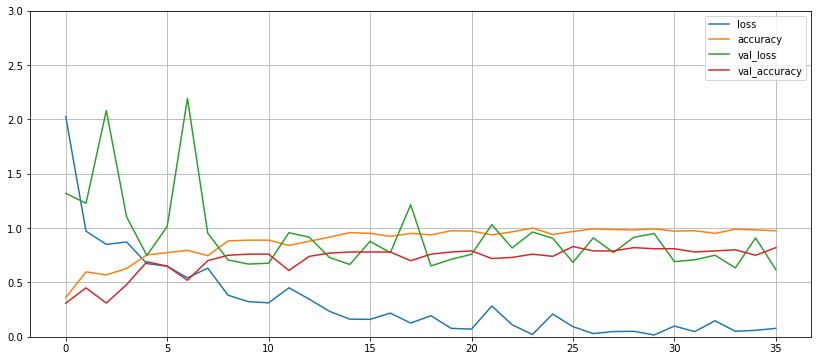

In [22]:
pd.DataFrame(history.history).plot(figsize=(14, 6))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()

# 분석

In [23]:
from sklearn.metrics import confusion_matrix
y_true = valid_y
y_prob = model.predict(valid_x)
y_pred = np.argmax(y_prob, axis=1)
cm = confusion_matrix(y_true, y_pred)
cm

array([[26,  1,  0,  0],
       [ 0, 21,  4,  1],
       [ 0,  4, 14,  5],
       [ 0,  0,  3, 21]])

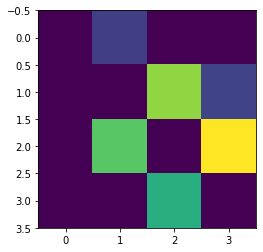

In [24]:
s = cm.sum(axis=1)
cm = cm / s
np.fill_diagonal(cm, 0)
plt.imshow(cm)